# Exploring the Bitcoin database


## Analyzing the transactions dataset
The first step after acquiring the dataset from the Bitcoin DB was to properly reduce it's size and transform it to a nice dataset (as a numpy data array). This was achieved by dumping the .dat files produced by the modified Bitcoin client (see https://github.com/dkondor/bitcoin/tree/0.16 for more info) to a database engine, and then querying it to extract the reduced data array.

Query used to create the transaction dataset:
```sql
select
  tx.txID as id,
  bh.block_timestamp as timestamp,
  addresses.address as src_addr,
  tx.n_inputs,
  tx.n_outputs,
  sum(txin.sum) as inputs_sum,
  sum(txout.sum) as outputs_sum,
  min(txin.sum) as min_input,
  max(txin.sum) as max_input,
  min(txout.sum) as min_ouput,
  max(txout.sum) as max_output
from
  tx
  join bh on tx.blockID = bh.blockID
  join txin on tx.txID = txin.txID
  join txout on tx.txID = txout.txID
  join addresses on txin.addrID = addresses.addrID
group BY
  tx.txID
```

In [1]:
# Helper functions to load the data and prepare it in some way

import numpy as np
import os

BH_FILE = "bh.dat"
TX_FILE = "tx.dat"
TXIN_FILE = "txin.dat"
TXOUT_FILE = "txout.dat"

LINE_BATCH_SIZE = 500


def load_dat(path, as_ndarray=False, cast_to=None, start=0, n_lines="all"):
    """
     Read 'n_lines' lines starting from line 'start' from the file 'path'.
     Return numpy array or list of tuples.
    """
    result_list = []
    with open(path, "r") as fh:
        for i, line in enumerate(fh):
            if i >= start and (n_lines == "all" or n_lines > 0):
                split_line = line.split()
                cast_line = map(cast_to, split_line) if cast_to is not None else split_line
                result_list.append(tuple(cast_line))
                if type(n_lines) is not str:
                    n_lines -= 1
    return np.array(result_list) if as_ndarray else result_list

In [2]:
# Loading the transactions data

TX_DATASET_PATH = "../btc_data/transactions.txt"

tx_dataset = load_dat(TX_DATASET_PATH, as_ndarray=True, start=2, cast_to=np.float32)
print(f"Transaction dataset shape: {tx_dataset.shape}")
print(f"Memory used by the transactions dataset: {tx_dataset.nbytes} bytes")
print(f"Data type of the transactions dataset: {tx_dataset.dtype}")

tx_dataset_cols = load_dat(TX_DATASET_PATH, n_lines=1)[0]
print("Column names of the transactions dataset:\n", tx_dataset_cols)

Transaction dataset shape: (1642765, 11)
Memory used by the transactions dataset: 72281660 bytes
Data type of the transactions dataset: float32
Column names of the transactions dataset:
 ('id', 'timestamp', 'src_addr', 'n_inputs', 'n_outputs', 'inputs_sum', 'outputs_sum', 'min_input', 'max_input', 'min_ouput', 'max_output')


## Description of the transactions dataset:
The dataset contains 1 642 765 last transaction created on the Bitcoin network as of Feb 2018. The columns present in the dataset are as follows:
* **id** - the ID of a given transaction
* **timestamp** - Unix timestamp of when the transaction has been issued (closly tied to the time of creation of a the block in which this transaction has been added)
* **src_addr** - represents the address (based on the public key) of the user who created this transaction
* **n_inputs** - number of input transactions attached to this transaction
* **n_outputs** - number of output transactions defined by this transaction
* **inputs_sum** - the total sum of currency value for the input transactions to this transaction
* **outputs_sum** - the total sum of currency value for the output transaction o this transaction
* **min_input** - the miniaml currency value of an input to this transaction
* **max_input** - the maximal currency value of an input to this transaction
* **min_output** - the minimal currencly value of an output defined by this transaction
* **max_output** - the maximal currency value of an output defined by this transaction

*All currency values are to be interpreted as multiplies of Satoshis (1e-8 BTC)*

In [3]:
# An important step of the analysis was to make sure that the data is in the proper
# type, that there are no Null values and the the data is semantically correct
# We also want to make sure that some columns (like n_inputs or n_outputs) are not negative.


def ensure_cols_non_negative(dataset, cols):
    for index in cols:
        dataset_slice = dataset[:, index]
        negatives = dataset_slice[dataset_slice < 0]
        if len(negatives) > 0:
            raise ValueError(f"Column {index} contained a negative value!")


def ensure_cols_not_nan(dataset, cols):
    for index in cols:
        dataset_slice = dataset[:, index]
        nans = dataset_slice[dataset_slice == np.NaN]
        if len(nans) > 0:
            raise ValueError(f"Column {index} contained a NaN value!")


ensure_cols_non_negative(tx_dataset, [1, 3, 4, 5, 6, 7, 8, 9, 10])
ensure_cols_not_nan(tx_dataset, range(11))

Mając pewność, że dane są w odpowiednim formacie oraz brak w nich niedopuszczalnych wartości możemy przejść do faktycznej części związanej z eksploracją. W pierwszym kroku policzone zostaną podstawowe statystyki zebranego zbioru danych (**średnie, odchylenia standardowe**, etc).

In [4]:
import pandas as pd

tx_dataframe = pd.DataFrame(data=tx_dataset, columns=tx_dataset_cols)
tx_dataframe.describe()

/home/patryk/.pyenv/versions/3.7.6/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,id,timestamp,src_addr,n_inputs,n_outputs,inputs_sum,outputs_sum,min_input,max_input,min_ouput,max_output
count,1.642765e+06,1.642765e+06,1642765.0,1.642765e+06,1.642765e+06,1.642765e+06,1.642765e+06,1.642765e+06,1.642765e+06,1.642765e+06,1.642765e+06
mean,2.975028e+08,1.517750e+09,337005920.0,3.828510e+00,2.809052e+00,1.251236e+09,1.084558e+09,2.107748e+08,2.501226e+08,3.168299e+07,2.521970e+08
std,4.746007e+05,1.927843e+05,70769608.0,2.225318e+01,1.844658e+01,6.212978e+09,5.959210e+09,8.275816e+08,8.978593e+08,2.671221e+08,9.023756e+08
min,2.966811e+08,1.517425e+09,76316.0,1.000000e+00,1.000000e+00,3.000000e+02,0.000000e+00,1.000000e+00,3.000000e+02,0.000000e+00,0.000000e+00
25%,2.970921e+08,1.517577e+09,341471360.0,1.000000e+00,2.000000e+00,3.358684e+06,2.334742e+06,6.860410e+05,1.503376e+06,1.210000e+05,1.472375e+06
50%,2.975031e+08,1.517758e+09,368037376.0,1.000000e+00,2.000000e+00,2.691864e+07,1.915268e+07,5.522000e+06,1.132616e+07,9.443740e+05,1.105079e+07
75%,2.979141e+08,1.517921e+09,369075712.0,1.000000e+00,2.000000e+00,1.934057e+08,1.282015e+08,5.768067e+07,8.312874e+07,4.605574e+06,8.203275e+07
max,2.983251e+08,1.518087e+09,370269472.0,1.099000e+03,3.351000e+03,9.999997e+10,9.999997e+10,9.999999e+09,9.999999e+09,9.999999e+09,9.999999e+09


### Podsumowanie statystyk
Jedną z pierwszych rzeczy, która rzuca się w oczy jest fakt, że niektóre z cech posiadają bardzo dużą wariancję. Cech te są powiązane z ilością waluty w obiegu. Przykładowo odchylenie standardowe cechy reprezentujące maksymalną kwotę wyjściową transakcji jest równe ok. 10e8. Wynika to z faktu, iż system walutowy Bitcoina jest dość zfragmentaryzowany - każda transakcja, której suma wejść przekracza sumę wyjść musi w rezultaci de facto tworzyć nową pomocniczą transakcję na swój adres, tak aby reszta z powrotem wróciła na nasze konto. W związku z tym w sieci mogą istnieć transakcje o na prawdę dużych kwotach (liczonych w miliardach satoshi), a jednocześnie istnieć może mnóstwo transakcji o małej wartości wynikających z w/w kwoty zwrotnej.

Ciekawa jest też analiza cechy src_adddr. Co prawda nie reprezentuje ona żadnej faktycznej wartości liczbowej, jednak i tak może dowiedzieć się ciekawych faktów z analizy jej momentów. I tak przykładowo minimalna wartośc tej cechy to 76316, co oznacza, że w przygotowanym przez nas zbiorze wystąpiły transakcję stworzone przez osobę od bardzo niskim indentyfikatorze, co z kolei oznacza, że osoba ta należała do grupy początkowych użytkoników sieci Bitcoin.

Warto również zaznaczyć, że maksymlna wartość pola srd_addr to ponad 370 mln. - możemy to interpretować jako fakt, iż w sieci Bitcoin istnieje obecnie taka właśnie ilość adresów (nie jest to jednak jednoznaczne z liczbą fizycznych użytnikowników, których jest na pewno zdecydowanie mniej z uwagi na fakt, że obecnie zaleca się aby każdą transakcję wykonywać z osobnego adresu publicznego, poza tym fragmentaryzacja majątku na różne adresy jest dobą praktyką jeśli chodzi o bezpieczeństwo).

Jedną z najistotniejszych statystyka w kontekście zrozumienia dynamiki całej sieci jest na pewno średnia ilość wejść do transakcji (i analogicznie - średnia ilość wyjść). W przypadku analizowanego przez nas wycinka czasowego transkacji średnia ilość wejść wyniosła 3.83, zaś średnia ilość wyjść niewiele mniej, bo 2.81. Średnią ilość wyjść można dość łatwo zainterpretować: często transakcja "powołuje" się na tyle wejść, że te nie sumują się dokładnie do jej wartości, wtedy do powstałej reszty tworzone jest nowe wyjść na adres twórcy. Mechaznim ten pozwala sugerować, że średnia ta powinna być nieco mniejsza niż 2.0, gdyż zdarzają się transakcje, których suma wejść jest dokładnie równa sumie wyjść. Jednak należy pamiętać, że w systemie możliwe są również bardziej rozbudowane transakcję wysyłające środki do wielu różnych odbiorców - to właśnie powoduje, że średnia ilość wyjść jest wyraźnie większa niż 2.0. Znacznie cięższa do interpretacji jest wartość średniej ilości wejść. W tym przypadku możemy jedynie postawić hipotezę, że wspomniana wcześniej fragmenryzacja zbioru transakcji faktycznie występuje, ale nie jest aż tak intensywna jak możnaby na początku zakładac.

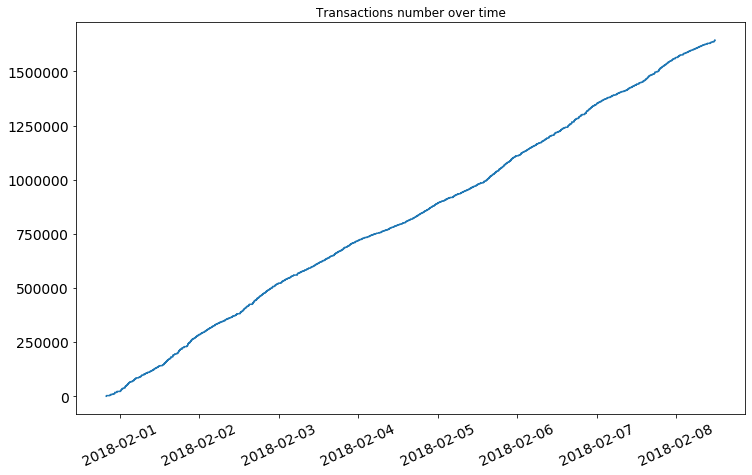

In [5]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.dates as md
import datetime as dt
import time
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))
tx_timestamps = tx_dataframe['timestamp']
tx_ids = np.copy(tx_dataframe['id']).astype(int)
txmin = min(tx_ids)
txmax = max(tx_ids)
tx_ids -= txmin
tx_dates = [dt.datetime.fromtimestamp(ts) for ts in tx_timestamps]


plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax=plt.gca()

xfmt = md.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)

y_formatter = ScalarFormatter(useOffset=False)
y_formatter.set_scientific(False)
ax.yaxis.set_major_formatter(y_formatter)

plt.title("Transactions number over time")
ax.plot(tx_dates, tx_ids)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

Widzimy, że ilość transakcji zrealizowana w danym okresie czasu jest liniowa, co za tym idzie, przyrost transakcji jest stały. Oznacza to, że mniej więcej tyle samo transakcji było realizowanych każdego dnia.

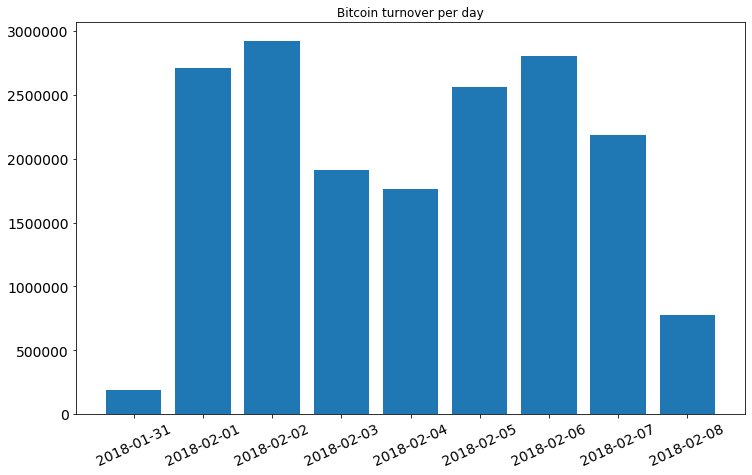

In [6]:
import itertools
plt.figure(figsize=(12, 8))
timestamps = tx_dataframe['timestamp']
outputs_sum = np.copy(tx_dataframe['outputs_sum'])
outputs_sum_in_btc = outputs_sum / 1e8
dates = [dt.datetime.fromtimestamp(ts) for ts in timestamps]

records = zip(dates, outputs_sum_in_btc)

turnover = [(datetime, sum(val for day, val in grp)) for datetime, grp in itertools.groupby(records, key=lambda x: x[0].date())]

dates, sums = zip(*turnover)

plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax=plt.gca()

xfmt = md.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)


y_formatter = ScalarFormatter(useOffset=False)
y_formatter.set_scientific(False)
ax.yaxis.set_major_formatter(y_formatter)

plt.title("Bitcoin turnover per day")
ax.bar(dates, sums)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

Tutaj wyniki są dość zaskakujące. Jeżeli założymy, że dane z pierwszego oraz ostatniego dnia są niepełne i odrzucimy je w analizie rezultatów to wciąż widzimy znaczną rozbieżność między obrotem bitcoina w dniach 3-4.02.2018 oraz w pozostałych dniach.

Rozwiązaniem zagadki zdaje się być informacje o dniu tygodnia, w który wypadają poszczególne dni. Okazuje się bowiem, że wspomniane dni o mniejszym obrocie kryptowaluty są odpowiednio sobotą oraz niedzielą, a pozostałe dni natomiast wypadają w dni robocze.

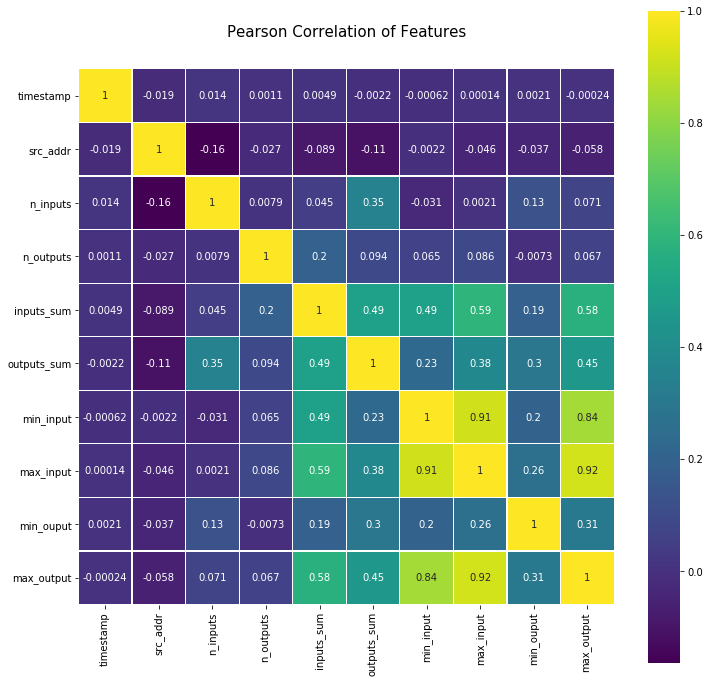

In [7]:
import seaborn as sns

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title("Pearson Correlation of Features", y=1.05, size=15)
sns.heatmap(tx_dataframe.iloc[:, 1:].astype(float).corr(), linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)

## Analiza PCA
W następnym kroku przeprowadzone zostanie analiza głównych składowych zbioru transakcji. Posłużymy się w tym celu klasą PCA z biblioteki sklearn.

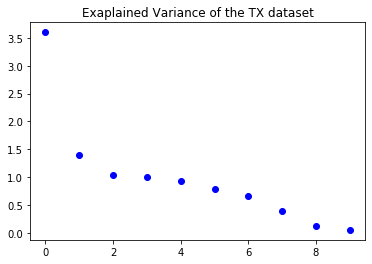

In [4]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from matplotlib import pyplot as plt

# zalecanym pierwszym krokiem jest odpowiednie przeskalowanie zbioru danych
scaler = preprocessing.StandardScaler()

# Wyrzucamy kolumnę ID
scaled_tx_dataset = scaler.fit_transform(tx_dataset[:, 1:])

# dopiero teraz można przejść do faktycznej analizy PCA

pca = PCA()
transformed_tx_dataset = pca.fit_transform(scaled_tx_dataset)

plt.title("Exaplained Variance of the TX dataset")
plt.plot(pca.explained_variance_, 'bo')
plt.show()

Bezwzględne wartości wariancji mogą być mylące więc pomocne jest również sporządzenie wykresu wartości względnych:

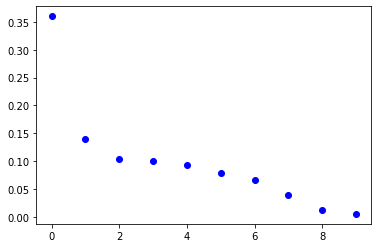

In [11]:
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.show()

Jak widać, pierwsza z cech odpowiada za znaczną część wariancji (czyli przenosi najwięce informacji - oczywiście przy zachowaniu założeń, jakie są wymagane do analizy PCA). Cechą tą jest timestamp transakcji. Pozostałe cechy mają dość równomierny rozkład, co pozwala stwierdzić, że żadna z nich nie określa jednoznacznie wariancji próbki.

In [12]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]
print("Attribute, PC1, PC2")
for i in range(0, pc1.shape[0]):
    print("Coords in feature space:" + repr(pc1[i]) + ":" + repr(pc2[i]))

Attribute, PC1, PC2
Coords in feature space:0.0013492937:0.041651968
Coords in feature space:-0.055295005:-0.39557773
Coords in feature space:0.07199168:0.65465206
Coords in feature space:0.0813536:0.056610502
Coords in feature space:0.39141592:0.04756681
Coords in feature space:0.3118438:0.45753974
Coords in feature space:0.45255437:-0.29096586
Coords in feature space:0.4928985:-0.2006614
Coords in feature space:0.21123642:0.24576336
Coords in feature space:0.49225152:-0.11436187


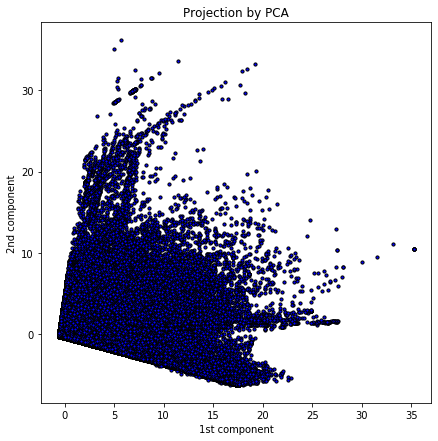

In [13]:
plt.figure(figsize=(7,7))
x = transformed_tx_dataset[:, 0]
y = transformed_tx_dataset[:, 1]
plt.scatter(x, y, c="blue", s=10, edgecolor="k")
plt.title("Projection by PCA")
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.show()

Na wykresie projekcji do 2D widać wyraźnie narożnik wynikający prawdopodobnie z ucięcią całego blockchainu. Poza tym widać, że większość większość sampli skupia się z grubsza w jednym regionie.

In [14]:
# Policzmy średnią, czyli "Per-feature empirical mean, estimated from the training set"

average_tx = pca.mean_
print('Average transaction in feature space: ', average_tx)

Average transaction in feature space:  [ 9.2197952e-06 -9.1200554e-06  7.6392600e-05  2.5347003e-06
  4.4783151e-06  9.0392319e-07  9.9385704e-07  1.3089913e-06
 -4.8005259e-06  8.1952112e-07]


In [15]:
# Możemy również sprawdzić, w jakim stopniu będziemy w stanie odtworzyć dane
reconstructed_ = np.dot(pca.transform(scaled_tx_dataset)[:,:], pca.components_[:,:])
reconstructed_ += pca.mean_

print(scaled_tx_dataset[0, :])
print(reconstructed_[0, :])

[-1.6877625  -3.931551   -0.12710594 -0.04385923  1.6324837   0.7738866
  6.629118    6.066417    0.09084614  5.971089  ]
[-1.6877626  -3.9315536  -0.12710723 -0.04385641  1.6324879   0.77388287
  6.629119    6.0664196   0.09084495  5.97109   ]


Jak widać zachowanie wszystkich głównych składowych pozwala na idealną rekonstrukcję danych wejściowych.

In [16]:
# Rekonstrukcja z 5 głównych składowych jest już nawet całkiem dobra
reconstructed_5 = np.dot(pca.transform(scaled_tx_dataset)[:,:5], pca.components_[:5,:])
reconstructed_5 += pca.mean_

print(scaled_tx_dataset[0, :])
print(reconstructed_5[0, :])

[-1.6877625  -3.931551   -0.12710594 -0.04385923  1.6324837   0.7738866
  6.629118    6.066417    0.09084614  5.971089  ]
[-1.6660788  -3.8893876  -0.8619154  -0.86725247  3.580794    1.1479019
  5.7859483   5.8623657  -0.14831084  5.51529   ]


Warto również zbadać jak zachowają się inne warianty analizy PCA, np. SparsePCA (z dużym naciskiem na to, by wynikowe wektory były rzadkie)

In [17]:
from sklearn import decomposition

# Parametr ten określa nam wagę kary na normę L1, czyli jak bardzo zależy nam na rzadkości wynikowych wektorów
l1_panelty = 15.0
sparse_pca = decomposition.MiniBatchSparsePCA(alpha=l1_panelty, normalize_components=True)
sparse_pca.fit(scaled_tx_dataset)

pc1 = sparse_pca.components_[0]
pc2 = sparse_pca.components_[1]
print("Sparse PCA - Attribute, Sparse PC1, Sparse PC2")
for i in range(0, pc1.shape[0]):
    print("Sparse coords in feature space:" + repr(pc1[i]) + ":" + repr(pc2[i]))

/home/patryk/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/decomposition/_sparse_pca.py:23: FutureWarning: 'normalize_components' has been deprecated in 0.22 and will be removed in 0.24. Remove the parameter from the  constructor.
  " constructor.", FutureWarning


Sparse PCA - Attribute, Sparse PC1, Sparse PC2
Sparse coords in feature space:-0.16047815917919508:-0.08199086762412387
Sparse coords in feature space:-0.051151123845707726:0.0
Sparse coords in feature space:0.042192297026888086:0.6858365076195906
Sparse coords in feature space:-0.272916313050361:-0.17531834275667008
Sparse coords in feature space:0.10686272903544129:0.0
Sparse coords in feature space:0.2672408244555882:0.4776584771989061
Sparse coords in feature space:0.35289814490523097:-0.28583983875335306
Sparse coords in feature space:0.47148647225752083:-0.34203819869790536
Sparse coords in feature space:0.5019370226489556:0.2555663169735417
Sparse coords in feature space:0.46233337439630295:-0.0017190511952563702


Postanowiliśmy również przebadać różne kernele do PCA. Wyniki poniżej:

In [ ]:
# Kernel PCA - RBF (gamma = 0.05)
kernel_rbf_pca = decomposition.KernelPCA(kernel='rbf', gamma = 0.05)
kernel_rbf_pca.fit(scaled_tx_dataset)

# TODO: too much memory required for data matrix

Reasumując, postanowiliśmy zachować wszystkie cechy wejściowe, gdyż każda z nich w dość istotny sposób dodaje swój wkład do entropii całego zbioru danych.

## Analiza TSNE
*A popular method for exploring high-dimensional data is something called t-SNE, introduced by van der Maaten and Hinton in 2008 [1]. The technique has become widespread in the field of machine learning, since it has an almost magical ability to create compelling two-dimensonal “maps” from data with hundreds or even thousands of dimensions.*
Source: https://distill.pub/2016/misread-tsne/

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=1000, verbose=2, perplexity=50.0)

# because the full dataset is very big, calculating the nearset neighbours for TSNE
# would take way too long time so for the sake of this visualization we trim
# the dataset to a more reasonable size

scaled_tx_dataset_tsne = preprocessing.StandardScaler().fit_transform(tx_dataset[:1000, 1:])

tsne_scaled_tx_dataset_res = tsne.fit_transform(scaled_tx_dataset_tsne)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.006002
[t-SNE] Computed conditional probabilities in 0.087s
[t-SNE] Iteration 50: error = 56.8349266, gradient norm = 0.2136910 (50 iterations in 0.189s)
[t-SNE] Iteration 100: error = 54.5650787, gradient norm = 0.1482115 (50 iterations in 0.149s)
[t-SNE] Iteration 150: error = 54.5636597, gradient norm = 0.1640913 (50 iterations in 0.172s)
[t-SNE] Iteration 200: error = 54.5238876, gradient norm = 0.1513753 (50 iterations in 0.139s)
[t-SNE] Iteration 250: error = 54.5298271, gradient norm = 0.1393979 (50 iterations in 0.143s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.529827
[t-SNE] Iteration 300: error = 0.3371665, gradient norm = 0.0004692 (50 iterations in 0.123s)
[t-SNE] Iteration 350: error = 0.3042734, gradient norm = 0.0002

In [30]:
def plot_2d_scatter(X):
    fig, plot = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.prism()
    
    plot.scatter(X[:, 0], X[:, 1], c=(0,0,0), alpha=0.5)

    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


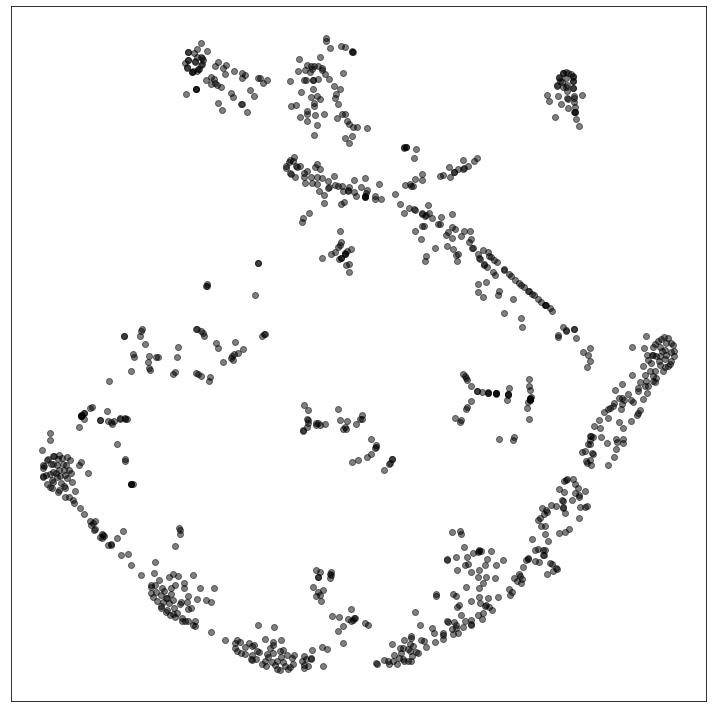

In [31]:
plot_2d_scatter(tsne_scaled_tx_dataset_res)

## Wykrywanie elementów odstających

W celu przeprowadzenie podstawowej analizy elementów odstających posłużyliśmy się implementacją algorytmu Local Outlier Factor pochodzącą z biblioteki SciKit-Learn. Algorytm ten zawiera kilka elementów wspólnych z innymi algorytmami, które poznaliśmy w ramach tego przedmiotu (np. DBSCAN). Algorytm LOF bazuje na koncepcji lokalnej gęstości próbek (lokalność w tym przypadku mierzona jest jako miara k-najbliższych-sąsiadów). Porównując lokalną gęstość danej próbki z lokalnym gęstościami jej sąsiadów jesteśmy w stanie oszacować i wykryć te regiony, które posiadają zbliżoną wartość gęstości. Punkty, które posiadają zdecydowanie mniejsze gęstości niż ich sąsiedzi (wartość parametryzowana algorytmu, threshold) uznawane zostają jako elementy odstające.

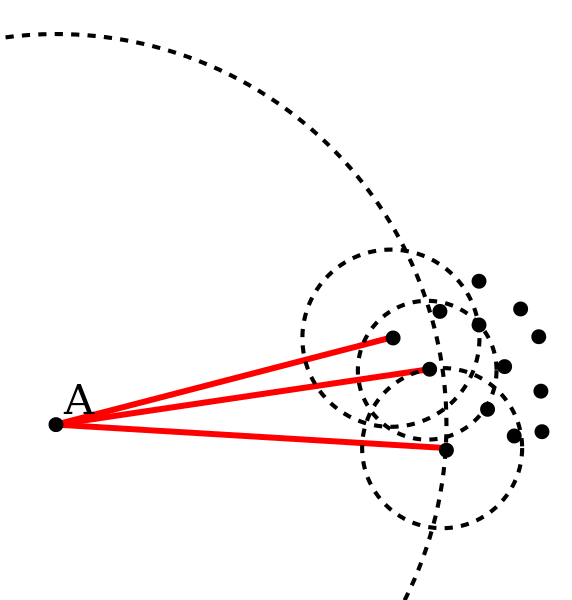

In [14]:
from IPython.display import display, Image
display(Image('images/lof.png'))

In [31]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

n_sampels_for_outlier_check = 50_000
scaled_tx_dataset_outlier = preprocessing.StandardScaler().fit_transform(tx_dataset[:n_sampels_for_outlier_check, 1:])


outlier_detector = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2)

outlier_mask = outlier_detector.fit_predict(scaled_tx_dataset_outlier)
n_outliers = len(outlier_mask[outlier_mask == -1])
print(f"Number of outliers detected in the first {n_sampels_for_outlier_check} TXs: {n_outliers}")
print(f"Outlier rate: {n_outliers / n_sampels_for_outlier_check}")

Number of outliers detected in the first 50000 TXs: 6154
Outlier rate: 0.12308


## Zbadanie zachowania różnych modeli regresji nieliniowej
W tej części przeprowadzona została regresja przygotowanego zbioru danych. Z uwagi na brak naturalnej kandydatki na cechę, którą będziemy starać się przewidywać za pomocą regresji postanowiliśmy dość arbitralnie wybrać jako Y kolumnę **inputs_sum**. Innymi słowy, będziemy starać się przewidzieć całkowitą sumę wejść do danej transakcji na podstawie pozostałych cech. 

In [21]:
# We are trimming the dataset a bit for this part;
n_sampels_regression = 10_000

# Scale the set
scaled_tx_dataset_regression = preprocessing.StandardScaler().fit_transform(tx_dataset[:n_sampels_regression, 1:])

# Remove the column we are trying to predict
X = np.delete(scaled_tx_dataset_regression, 4, axis=1)
# We are predicting the inputs_sum, which is the 4th column in the scaled dataset
Y = scaled_tx_dataset_regression[:, 4]

# Set the max number of iterations so that we don't get stuck during learning
n_max_iter = 1_000_000

print(X.shape)
print(Y.shape)

(10000, 9)
(10000,)


In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

print("Support Vector Regression")
svr = SVR(kernel="linear", C=1.0, epsilon=0.1, max_iter=n_max_iter)
print(f"{svr}. Cross-Val score: {cross_val_score(svr, X, Y, cv=5).mean()}")

Support Vector Regression
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=1000000, shrinking=True, tol=0.001,
    verbose=False). Cross-Val score: 0.19787938432003166


In [14]:
from sklearn.tree import DecisionTreeRegressor

print("Decision Tree Regressor")
dtr = DecisionTreeRegressor(criterion="mse", splitter="best", max_depth=5)
print(f"{dtr}. Cross-Val score: {cross_val_score(dtr, X, Y, cv=5).mean()}")

Decision Tree Regressor
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'). Cross-Val score: 0.6070489442849712


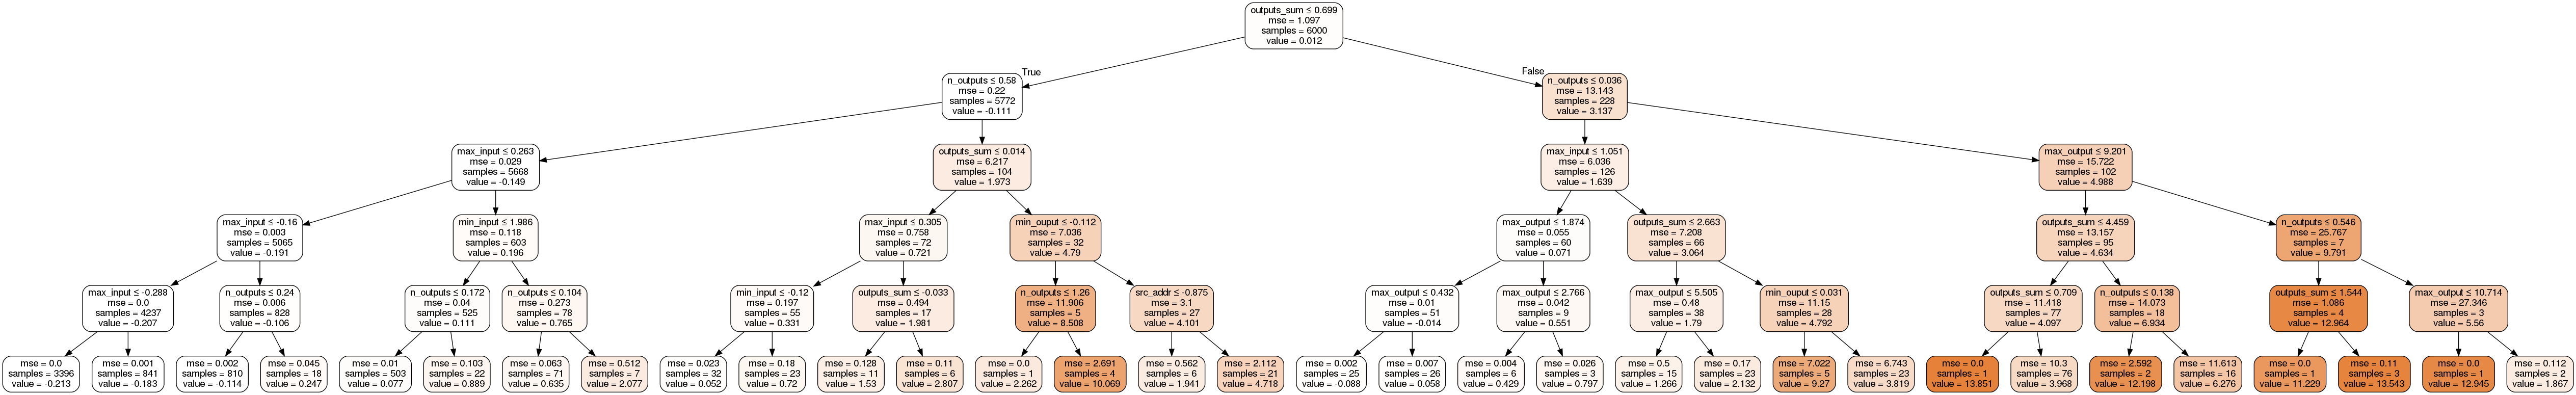

In [15]:
from sklearn.externals.six import StringIO 
from sklearn import tree
import pydotplus
from IPython.display import Image
from sklearn.model_selection import train_test_split
import os

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
dtr.fit(X_train, y_train)

dot_data = StringIO()
tree.export_graphviz(dtr, 
    out_file=dot_data,
    feature_names=np.array(tx_dataset_cols)[[1, 2, 3, 4, 6, 7, 8, 9, 10]],
    filled=True,
    rounded=True,
    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

Regressor drzew decyzyjnych wypadł znacznie lepiej niż prosta maszyna wektorów nośnych z liniowym jądrem (uzyskując accuracy na poziomie ~61%). Przetestowane zostałe różne warianty parametru maksymalnej głębokości drzewa (bez limit, 3, 4, 5, 6, 10, 100). Najlepszy rezultat testu walidacji krzyżowej uzyskano dla głębokości równej 5 (rysunek powyżej).

In [23]:
from sklearn.neural_network import MLPRegressor

print("Multi Layer Perceptron Regressor")
mlp = MLPRegressor(hidden_layer_sizes=(10, 15, 5), activation='relu', solver='adam', alpha=0.0001, max_iter=500)
print(f"{mlp}. Cross-Val score: {cross_val_score(mlp, X, Y, cv=5).mean()}")

Multi Layer Perceptron Regressor
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 15, 5), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False). Cross-Val score: 0.5393123010520051


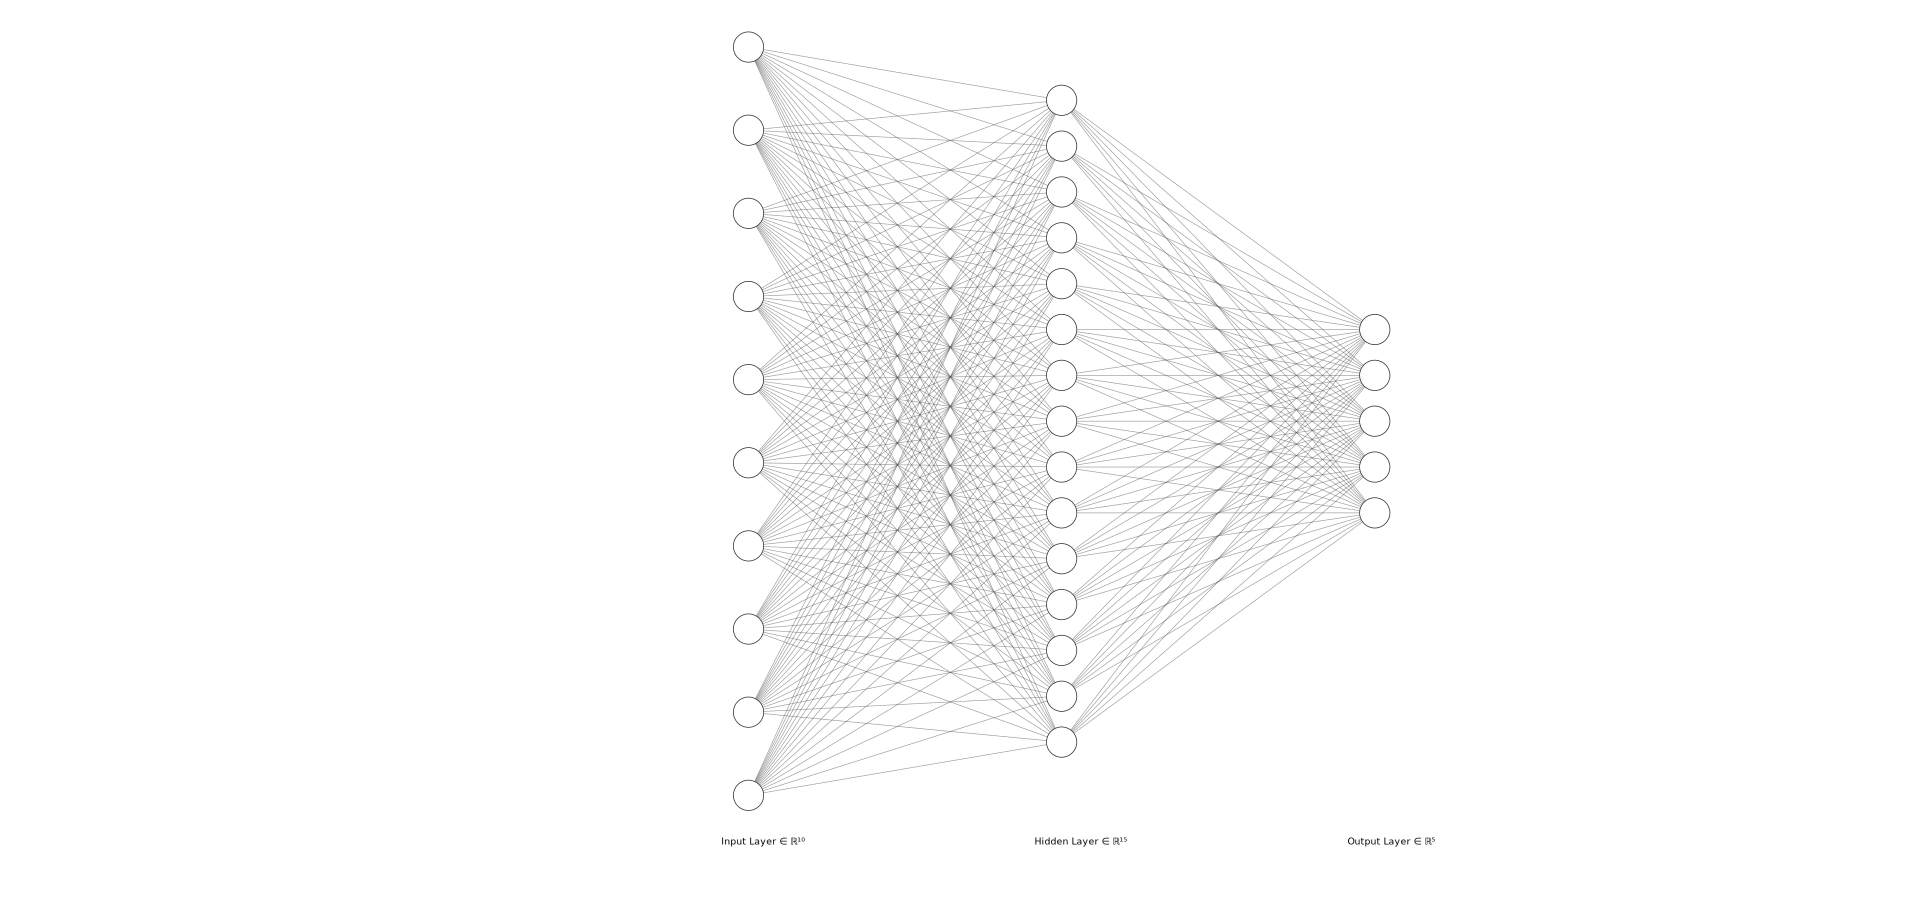

In [13]:
from IPython.display import SVG, display
display(SVG('images/nn.svg'))

Niestety wstępne testy MLP nie zakończyły się znaczącym sukcesem, accuracy w najlepszym wypadku orbitowało wokół ~55%.

## Klasteryzacja
W tej części użyjemy algorytmu k-means to przeprowadzenia analizy nienadzorowanej.

In [16]:
# WARNING!!!
# This cell runs for about 1h, so be carefull when clearing it's output.

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

max_iterations = 30
ks_to_test = [10, 100, 1000]

# prepare the initial dataset;
# we perform the clusterization on the src_addr (so we clusterize the txs
# by the address of the issuer)

# Scale the set
scaled_tx_dataset_cluster = preprocessing.StandardScaler().fit_transform(tx_dataset[:, 1:])

# Remove the column we are trying to predict
X = np.delete(scaled_tx_dataset_cluster, 1, axis=1)
# We are predicting the inputs_sum, which is the 4th column in the scaled dataset
Y = scaled_tx_dataset_cluster[:, 1]

number_of_features = X.shape[1]

print("Measuring the quality of different initialization schemas for k-means for different k values...")

for k in ks_to_test:
    
    print(f"-----k = {k}-----")
    print("Showing values of the Davies-Bouldin score for different init methods:")
    
    # prepare all the differently initialized cluster algorithms instances:
    # first we need to create a custom init array for the 'Random' init case since Sklearn doesn't have it
    random_init = np.random.uniform(0, 1, (k, number_of_features))
    
    kmeans_instances = {
        'random': KMeans(n_clusters=k, random_state=0, n_init=1, algorithm='full', max_iter=max_iterations, init=random_init),
        'forgy': KMeans(n_clusters=k, random_state=0, n_init=1, algorithm='full', max_iter=max_iterations, init='random'),
        'k_means++': KMeans(n_clusters=k, random_state=0, n_init=1, algorithm='full', max_iter=max_iterations, init='k-means++')
    }
    
    kmeans_instances['random'].fit(X)
    print('random: ', davies_bouldin_score(X, kmeans_instances['random'].labels_))
    
    kmeans_instances['forgy'].fit(X)
    print('forgy: ', davies_bouldin_score(X, kmeans_instances['forgy'].labels_))
    
    kmeans_instances['k_means++'].fit(X)
    print('k_means++: ', davies_bouldin_score(X, kmeans_instances['k_means++'].labels_))

Measuring the quality of different initialization schemas for k-means for different k values...
-----k = 10-----
Showing values of the Davies-Bouldin score for different init methods:
random:  0.9336513655892233
forgy:  1.20668304371832
k_means++:  0.9598164631218022
-----k = 100-----
Showing values of the Davies-Bouldin score for different init methods:
random:  1.106517064229953
forgy:  1.2643305084706882
k_means++:  1.1349175817749195
-----k = 1000-----
Showing values of the Davies-Bouldin score for different init methods:
random:  0.7103612783691173
forgy:  1.1968193832991314
k_means++:  1.1424115458122104


Współczynnik Davies-Boulding (zaproponowany w 1979 roku przez Davies, David L. oraz Bouldin, Donald W. - https://ieeexplore.ieee.org/document/4766909) zdefiniowany jest jako średnia miary podobności klastra z najbardziej podobnym mu innym klastrem, gdzie podobność jest stosunkiem dystansów wewnątrz danego klastra do dystanów pomiędzy klastrami. Dzięki temu klastry, które są dalej oddalone od siebie będą miały lepszą wartość współczynnika (minimalną wartością jest 0, zaś mniejsze wartości oznaczją lepszą klasteryzację).

W naszym przypadku średnio najlepsze wartości współczynnika Davies-Bouldin otrzymaliśmy dla ilości klastrów równej 1000. Jest tak ponieważ analizowany zakres czasowy jest dość mały w stosunku do zakresu obejmującego pełny czas pracy sieci Bitcoin co powoduje, że w obszarze tym raczej spodziewalibyśmy się dużej ilości transakcji pochodzących od różnych kont.

Warto również zwrócić uwagę na to jak istotny wpływ na końcową jakość przeprowadzonej klasteryzacji (przy zadanej z góry ilości iteracji treningowych) ma wybór metody inicjalizacji początkowych centroidów. W analizowanym zbiorze danych zdecydowanie najlepsza okazała się metoda losowej inicjalizacji (pokonując dość wyraźnie metodą Forgy'ego oraz k-means++). Jest to poniekąd oczekiwane zachowanie gdyż, transakcje w sieci w danym okresie z grubsza powinny pochodzić od losowych kont oraz cechować jest losowym rozkład badanych cech.

## Algorytm DBSCAN
DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Znajduje główne próbki o wysokim współczynniku skupienia i następnie rozszerza je na odrębne klastry. Nadaje się głównie do zbiorów, w których klastry naturalnie posiadają zbliżoność wartość gęstości próbek (czyli nadaje się idealnie do naszego przypadku).

In [27]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# We are trimming the dataset a bit for this part to better visualize it
n_sampels_dbscan = 10_000

# Scale the set
scaled_tx_dataset_dbscan = preprocessing.StandardScaler().fit_transform(tx_dataset[:n_sampels_dbscan, 1:])

# Remove the column we are trying to predict
X = np.delete(scaled_tx_dataset_dbscan, 1, axis=1)
# We are predicting the inputs_sum, which is the 4th column in the scaled dataset
Y = scaled_tx_dataset_dbscan[:, 1]

labels_true = Y

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 8
Estimated number of noise points: 890
Homogeneity: 0.158
Completeness: 0.837
V-measure: 0.266
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.094
Silhouette Coefficient: 0.388


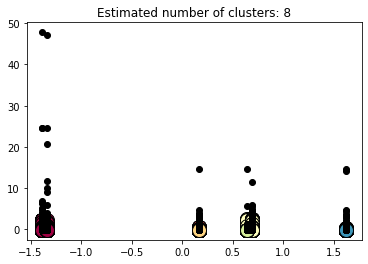

In [28]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Jak widać algorytm DBSCAN wykrał, że transakcje w przygotowanym zbiorze danych skupiają się w 8 klastrach, czyli w datasecie możliwe do wykrycia jest 8 potecjalnie różnych pod względem charaktyrystki cech grup transakcji stworzonych przez dane konto.

# Pozostałe wizualizacje

W tej sekcji zawarte są różne wizualizacje przygotowanego zbioru danych mające na celu lepsze zrozumienie charakterystyk i zależności w nim występujących.

In [20]:
trimmed_columns_tx_dataframe = tx_dataframe.iloc[:, 1:]

## Histogram adresów źródłowych transakcji

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bfbd13110>]],
      dtype=object)

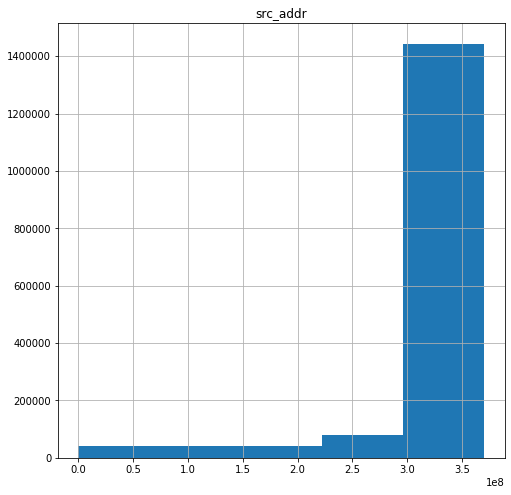

In [19]:
trimmed_columns_tx_dataframe.hist(bins=5, figsize=(8, 8), column="src_addr")

## Histogram znaczników czasowych transakcji

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bfbc15410>]],
      dtype=object)

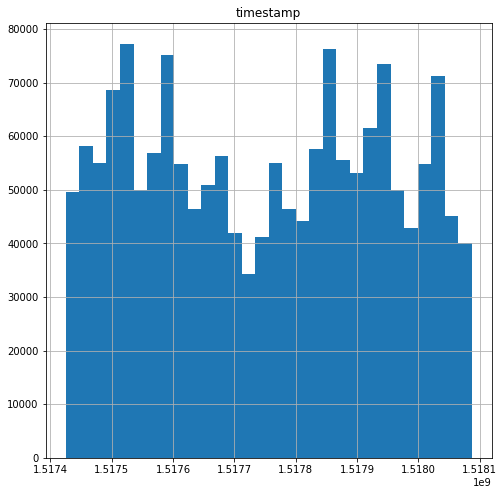

In [24]:
trimmed_columns_tx_dataframe.hist(bins=30, figsize=(8, 8), column="timestamp")

## Boxplot znaczników czasowych

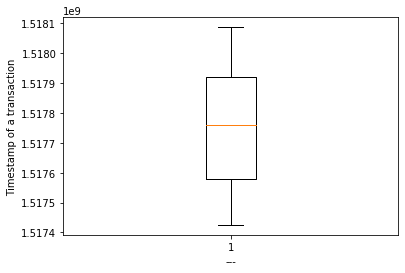

In [37]:
plt.boxplot(trimmed_columns_tx_dataframe["timestamp"])
plt.ylabel("Timestamp of a transaction")
plt.xlabel("---")
plt.show()

# Dataset zagregowanych danych o sieci BTC

Podczas pracy z głównym, ręcznie przygotowanym datasetem natrafiliśmy się również na bardzo ciekawe zbiór, w którym autorzy przygotowali wartości ciekawych metryk sieci BTC w każdym dniu licząc od bloku genesis. Postanowiliśmy przynajmniej w podstawowym zakresie przeanalizować go pod kątem eksploracji danych.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

BTC_DATASET_PATH = "../btc_datahub/bitcoin_csv.csv"

btc_df = pd.read_csv(BTC_DATASET_PATH)
btc_df.tail()

,date,txVolume(USD),adjustedTxVolume(USD),txCount,marketcap(USD),price(USD),exchangeVolume(USD),generatedCoins,fees,activeAddresses,averageDifficulty,paymentCount,medianTxValue(USD),medianFee,blockSize,blockCount
3600,2018-11-18,1.976557e+09,1.304067e+09,239680,9.664468e+10,5559.74,4.159680e+09,1537.5,18.037467,549212,6.653303e+12,301260.0,78.226098,0.000031,117375788,123
3601,2018-11-19,4.480410e+09,2.620049e+09,267845,9.771459e+10,5620.78,7.039560e+09,1575.0,39.969486,674503,6.653303e+12,361918.0,151.592437,0.000076,138689706,126
3602,2018-11-20,5.838062e+09,3.944652e+09,288318,8.456520e+10,4863.93,8.428290e+09,1650.0,69.367650,768696,6.653303e+12,423180.0,260.945272,0.000117,158893720,132
3603,2018-11-21,3.406311e+09,2.220358e+09,254837,7.764452e+10,4465.54,6.120120e+09,1312.5,49.950160,628177,6.653303e+12,367256.0,161.673715,0.000101,127422353,105
3604,2018-11-22,2.759416e+09,1.711484e+09,265994,8.019071e+10,4611.57,4.569370e+09,1525.0,39.134218,656428,6.653303e+12,364559.0,104.883242,0.000076,148651548,122


In [10]:
btc_df.describe()

,txVolume(USD),adjustedTxVolume(USD),txCount,marketcap(USD),price(USD),exchangeVolume(USD),generatedCoins,fees,activeAddresses,averageDifficulty,paymentCount,medianTxValue(USD),medianFee,blockSize,blockCount
count,2.035000e+03,2.035000e+03,3605.000000,2.035000e+03,2035.000000,2.035000e+03,3605.000000,3605.000000,3.605000e+03,3.605000e+03,3.351000e+03,2035.000000,3351.000000,3.605000e+03,3605.000000
mean,2.735073e+09,1.139493e+09,99431.565326,3.771208e+10,2279.330865,1.434180e+09,4823.539125,51.504402,2.515554e+05,5.532081e+11,1.806366e+05,177.112048,0.000489,5.346078e+07,152.877115
std,5.160649e+09,1.970668e+09,104559.375595,5.861474e+10,3442.946652,3.035095e+09,2817.834929,107.765355,2.855449e+05,1.485977e+12,1.806980e+05,342.486667,0.006475,5.583618e+07,37.558325
min,3.287234e+07,2.053871e+07,0.000000,7.794864e+08,68.500000,0.000000e+00,200.000000,0.000000,4.000000e+00,1.000000e+00,0.000000e+00,0.024145,0.000000,8.600000e+02,4.000000
25%,2.523401e+08,1.027608e+08,5183.000000,4.380106e+09,320.220000,1.866320e+07,2412.500000,3.911432,1.198300e+04,1.090716e+06,1.008550e+04,51.360193,0.000000,2.274111e+06,138.000000
50%,7.898199e+08,2.824168e+08,59615.000000,8.121197e+09,596.330000,5.785860e+07,4049.997500,17.442879,1.329290e+05,9.083509e+08,1.313040e+05,76.016323,0.000100,3.072236e+07,153.000000
75%,3.428363e+09,1.557028e+09,194607.000000,4.237367e+10,2575.190000,1.180765e+09,6850.000000,43.215072,4.845470e+05,1.960614e+11,3.342495e+05,192.290392,0.000369,1.082456e+08,168.000000
max,4.835307e+10,1.624809e+10,490459.000000,3.261873e+11,19475.800000,2.384090e+10,34600.000000,1495.946477,1.283929e+06,7.454969e+12,1.883744e+06,4176.310572,0.220000,2.040237e+08,692.000000


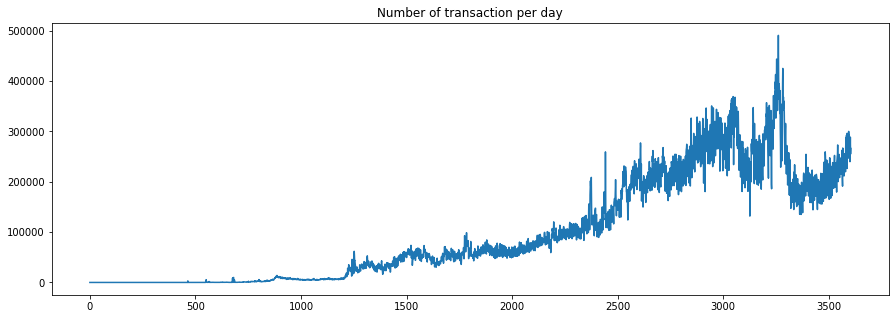

In [11]:
plt.figure(figsize=(15,5))
plt.title("Number of transaction per day")
btc_df["txCount"].plot()

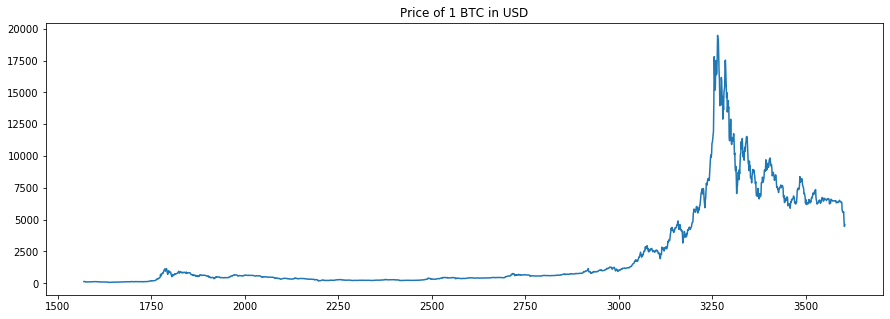

In [12]:
plt.figure(figsize=(15,5))
plt.title("Price of 1 BTC in USD")
btc_df["price(USD)"].plot()

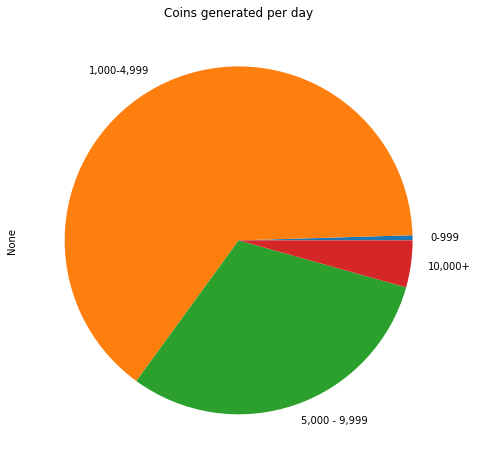

In [20]:
btc_df['bins'] = pd.cut(btc_df['generatedCoins'],bins=[0,1000,5000,10000,100000], \
                        labels=["0-999","1,000-4,999","5,000 - 9,999","10,000+"])
df_generated_coins_agg = btc_df.groupby('bins').size()

plt.figure(figsize=(8,8))
plt.title("Coins generated per day")
df_generated_coins_agg.plot.pie()

# Appendix
Pozostały kod źródłowy wytworzony w ramamch projektu:

In [24]:
def prepare_subblockchain(data_folder, new_data_folder, start_block, n_blocks):
    """
     Given data in the directory 'data_folder' extract from it a subset of 'n_blocks' blocks
     (and TXs associated with these blocks) starting with block 'start_block.
     Save the new blockchain in the directory 'new_data_folder' with the same structure
     as in 'data_folder'. Basically a vertical reduction of the blockchain.
     For now in only handles the files: BH, TX, TXIN, TXOUT.
    """
    print(f"Trimming {BH_FILE}... ")
    _handle_single_file(
        data_folder, new_data_folder, BH_FILE, start_block, n_blocks, LINE_BATCH_SIZE
    )

    print(f"Trimming {TX_FILE}... ")
    filter_func_tx = (
        lambda line: int(line[1]) >= start_block
        and int(line[1]) <= start_block + n_blocks
    )
    _handle_single_file(
        data_folder,
        new_data_folder,
        TX_FILE,
        start_block,
        n_blocks,
        LINE_BATCH_SIZE,
        filter_func=filter_func_tx,
    )

    filtered_txs = load_dat(
        path=os.path.join(new_data_folder, TX_FILE), start=0, n_lines="all"
    )
    filtered_txs_ids = [t[0] for t in filtered_txs]
    filter_func_tx_full = lambda line: line[0] in filtered_txs_ids

    print(f"Trimming {TXOUT_FILE}... ")
    _handle_single_file(
        data_folder,
        new_data_folder,
        TXOUT_FILE,
        start_block,
        n_blocks,
        LINE_BATCH_SIZE,
        filter_func=filter_func_tx_full,
    )

    print(f"Trimming {TXIN_FILE}... ")
    _handle_single_file(
        data_folder,
        new_data_folder,
        TXIN_FILE,
        start_block,
        n_blocks,
        LINE_BATCH_SIZE,
        filter_func=filter_func_tx_full,
    )
    print("Done.")


def _handle_single_file(
    old_dir,
    new_dir,
    file_name,
    start_block,
    n_blocks,
    batch_size,
    filter_func=lambda x: True,
):
    n_chunks = n_blocks // batch_size
    for j in range(n_chunks):
        _read_and_append_to_new(
            old_dir,
            new_dir,
            file_name,
            start_block + j * batch_size,
            batch_size,
            filter_func,
        )
    leftover = n_blocks % batch_size
    _read_and_append_to_new(
        old_dir, new_dir, file_name, start_block + j * batch_size, leftover, filter_func
    )


def _read_and_append_to_new(old_dir, new_dir, file_name, start, n_lines, filter_func):
    content = load_dat(os.path.join(old_dir, file_name), start=start, n_lines=n_lines)
    with open(os.path.join(new_dir, file_name), "a+") as fh:
        for line in content:
            if filter_func(line):
                fh.write(" ".join(list(line)) + "\n")